# Decision Transformer

Official Decision Transformer PyTorch implementation: https://github.com/kzl/decision-transformer

In [11]:
import math

import torch
import torch.nn as nn
from torch.nn import functional as F

import numpy as np
import gymnasium as gym 

import matplotlib.pyplot as plt
from IPython.display import clear_output

## Model

In [12]:
class GELU(nn.Module):
    def forward(self, input):
        return F.gelu(input)

class GPTConfig:
    """ base GPT config, params common to all GPT versions """
    embd_pdrop = 0.1
    resid_pdrop = 0.1
    attn_pdrop = 0.1

    def __init__(self, vocab_size, block_size, **kwargs):
        self.vocab_size = vocab_size
        self.block_size = block_size
        for k,v in kwargs.items():
            setattr(self, k, v)

class GPT1Config(GPTConfig):
    """ GPT-1 like network roughly 125M params """
    n_layer = 12
    n_head = 12
    n_embd = 768

In [14]:
class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads
        self.key = nn.Linear(config.n_embd, config.n_embd)
        self.query = nn.Linear(config.n_embd, config.n_embd)
        self.value = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_drop = nn.Dropout(config.attn_pdrop)
        self.resid_drop = nn.Dropout(config.resid_pdrop)
        # output projection
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("mask", 
            torch.tril(torch.ones(config.block_size + 1, config.block_size + 1))
            .view(1, 1, config.block_size + 1, config.block_size + 1)
        )
        self.n_head = config.n_head

    def forward(self, x, layer_past=None):
        B, T, C = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = self.query(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = self.value(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_drop(self.proj(y))
        return y

In [15]:
class Block(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.resid_pdrop),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

In [16]:
class GPT(nn.Module):
    """  the full GPT language model, with a context size of block_size """

    def __init__(self, config):
        super().__init__()

        self.config = config

        self.model_type = config.model_type

        # input embedding stem
        self.tok_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Parameter(torch.zeros(1, config.block_size + 1, config.n_embd))
        self.global_pos_emb = nn.Parameter(torch.zeros(1, config.max_timestep+1, config.n_embd))
        self.drop = nn.Dropout(config.embd_pdrop)

        # transformer
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])
        # decoder head
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.block_size = config.block_size
        self.apply(self._init_weights)


        print("number of parameters: %e", sum(p.numel() for p in self.parameters()))


        # self.state_encoder = nn.Sequential(nn.Conv2d(4, 32, 8, stride=4, padding=0), nn.ReLU(),
        #                          nn.Conv2d(32, 64, 4, stride=2, padding=0), nn.ReLU(),
        #                          nn.Conv2d(64, 64, 3, stride=1, padding=0), nn.ReLU(),
        #                          nn.Flatten(), nn.Linear(3136, config.n_embd), nn.Tanh())
        
        self.state_encoder = nn.Sequential(nn.Linear(4, config.n_embd), nn.Tanh())

        self.ret_emb = nn.Sequential(nn.Linear(1, config.n_embd), nn.Tanh())

        self.action_embeddings = nn.Sequential(nn.Embedding(config.vocab_size, config.n_embd), nn.Tanh())
        nn.init.normal_(self.action_embeddings[0].weight, mean=0.0, std=0.02)

    def get_block_size(self):
        return self.block_size

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def configure_optimizers(self, train_config):
        """
        This long function is unfortunately doing something very simple and is being very defensive:
        We are separating out all parameters of the model into two buckets: those that will experience
        weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
        We are then returning the PyTorch optimizer object.
        """

        # separate out all parameters to those that will and won't experience regularizing weight decay
        decay = set()
        no_decay = set()
        # whitelist_weight_modules = (torch.nn.Linear, )
        whitelist_weight_modules = (torch.nn.Linear, torch.nn.Conv2d)
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name

                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)

        # special case the position embedding parameter in the root GPT module as not decayed
        no_decay.add('pos_emb')
        no_decay.add('global_pos_emb')

        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params), )

        # create the pytorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
        return optimizer

    # state, action, and return
    def forward(self, states, actions, targets=None, rtgs=None, timesteps=None):
        # states: (batch, block_size, 4*84*84)
        # actions: (batch, block_size, 1)
        # targets: (batch, block_size, 1)
        # rtgs: (batch, block_size, 1)
        # timesteps: (batch, 1, 1)

        # state_embeddings = self.state_encoder(states.reshape(-1, 4, 84, 84).type(torch.float32).contiguous()) # (batch * block_size, n_embd)
        # for the CartPole-v1 state size is (4,), therefore:
        state_embeddings = self.state_encoder(states.reshape(-1, 4).type(torch.float32).contiguous()) # (batch * block_size, n_embd)
        state_embeddings = state_embeddings.reshape(states.shape[0], states.shape[1], self.config.n_embd) # (batch, block_size, n_embd)
        
        if actions is not None and self.model_type == 'reward_conditioned': 
            rtg_embeddings = self.ret_emb(rtgs.type(torch.float32))
            action_embeddings = self.action_embeddings(actions.type(torch.long).squeeze(-1)) # (batch, block_size, n_embd)

            token_embeddings = torch.zeros((states.shape[0], states.shape[1]*3 - int(targets is None), self.config.n_embd), dtype=torch.float32, device=state_embeddings.device)
            token_embeddings[:,::3,:] = rtg_embeddings
            token_embeddings[:,1::3,:] = state_embeddings
            token_embeddings[:,2::3,:] = action_embeddings[:,-states.shape[1] + int(targets is None):,:]
        elif actions is None and self.model_type == 'reward_conditioned': # only happens at very first timestep of evaluation
            rtg_embeddings = self.ret_emb(rtgs.type(torch.float32))

            token_embeddings = torch.zeros((states.shape[0], states.shape[1]*2, self.config.n_embd), dtype=torch.float32, device=state_embeddings.device)
            token_embeddings[:,::2,:] = rtg_embeddings # really just [:,0,:]
            token_embeddings[:,1::2,:] = state_embeddings # really just [:,1,:]
        elif actions is not None and self.model_type == 'naive':
            action_embeddings = self.action_embeddings(actions.type(torch.long).squeeze(-1)) # (batch, block_size, n_embd)

            token_embeddings = torch.zeros((states.shape[0], states.shape[1]*2 - int(targets is None), self.config.n_embd), dtype=torch.float32, device=state_embeddings.device)
            token_embeddings[:,::2,:] = state_embeddings
            token_embeddings[:,1::2,:] = action_embeddings[:,-states.shape[1] + int(targets is None):,:]
        elif actions is None and self.model_type == 'naive': # only happens at very first timestep of evaluation
            token_embeddings = state_embeddings
        else:
            raise NotImplementedError()

        batch_size = states.shape[0]
        all_global_pos_emb = torch.repeat_interleave(self.global_pos_emb, batch_size, dim=0) # batch_size, traj_length, n_embd

        position_embeddings = torch.gather(all_global_pos_emb, 1, torch.repeat_interleave(timesteps, self.config.n_embd, dim=-1)) + self.pos_emb[:, :token_embeddings.shape[1], :]

        x = self.drop(token_embeddings + position_embeddings)
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.head(x)

        if actions is not None and self.model_type == 'reward_conditioned':
            logits = logits[:, 1::3, :] # only keep predictions from state_embeddings
        elif actions is None and self.model_type == 'reward_conditioned':
            logits = logits[:, 1:, :]
        elif actions is not None and self.model_type == 'naive':
            logits = logits[:, ::2, :] # only keep predictions from state_embeddings
        elif actions is None and self.model_type == 'naive':
            logits = logits # for completeness
        else:
            raise NotImplementedError()

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))

        return logits, loss

## Utils

In [17]:
import random
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def top_k_logits(logits, k):
    v, ix = torch.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = -float('Inf')
    return out

@torch.no_grad()
def sample(model, x, steps, temperature=1.0, sample=False, top_k=None, actions=None, rtgs=None, timesteps=None):
    """
    take a conditioning sequence of indices in x (of shape (b,t)) and predict the next token in
    the sequence, feeding the predictions back into the model each time. Clearly the sampling
    has quadratic complexity unlike an RNN that is only linear, and has a finite context window
    of block_size, unlike an RNN that has an infinite context window.
    """
    block_size = model.get_block_size()
    model.eval()
    for k in range(steps):
        # x_cond = x if x.size(1) <= block_size else x[:, -block_size:] # crop context if needed
        x_cond = x if x.size(1) <= block_size//3 else x[:, -block_size//3:] # crop context if needed
        if actions is not None:
            actions = actions if actions.size(1) <= block_size//3 else actions[:, -block_size//3:] # crop context if needed
        rtgs = rtgs if rtgs.size(1) <= block_size//3 else rtgs[:, -block_size//3:] # crop context if needed
        logits, _ = model(x_cond, actions=actions, targets=None, rtgs=rtgs, timesteps=timesteps)
        # pluck the logits at the final step and scale by temperature
        logits = logits[:, -1, :] / temperature
        # optionally crop probabilities to only the top k options
        if top_k is not None:
            logits = top_k_logits(logits, top_k)
        # apply softmax to convert to probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution or take the most likely
        if sample:
            ix = torch.multinomial(probs, num_samples=1)
        else:
            _, ix = torch.topk(probs, k=1, dim=-1)
        # append to the sequence and continue
        # x = torch.cat((x, ix), dim=1)
        x = ix

    return x

## Обучение

In [18]:
import math

from tqdm.notebook import tqdm
import numpy as np

import torch
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data.dataloader import DataLoader

from collections import deque
import random
# import cv2
import torch
from PIL import Image

class TrainerConfig:
    # optimization parameters
    max_epochs = 10
    batch_size = 64
    learning_rate = 3e-4
    betas = (0.9, 0.95)
    grad_norm_clip = 1.0
    weight_decay = 0.1 # only applied on matmul weights
    # learning rate decay params: linear warmup followed by cosine decay to 10% of original
    lr_decay = False
    warmup_tokens = 375e6 # these two numbers come from the GPT-3 paper, but may not be good defaults elsewhere
    final_tokens = 260e9 # (at what point we reach 10% of original LR)
    # checkpoint settings
    ckpt_path = None
    num_workers = 0 # for DataLoader

    def __init__(self, **kwargs):
        for k,v in kwargs.items():
            setattr(self, k, v)

In [19]:
class Trainer:

    def __init__(self, model, train_dataset, test_dataset, config):
        self.model = model
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.config = config

        # take over whatever gpus are on the system
        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = torch.nn.DataParallel(self.model).to(self.device)

        self.losses = []
        self.epochs = []
        self.lrs = []
        self.eval_returns = []
        self.eval_epochs = []
        self.iter_cnt = 0
        self.eval_return = 0
        self.best_eval_return = float('-inf')
        self.best_checkpoint_path = None

    def save_checkpoint(self, path=None):
        # DataParallel wrappers keep raw model object in .module attribute
        raw_model = self.model.module if hasattr(self.model, "module") else self.model
        
        save_path = path if path is not None else self.config.ckpt_path
        import os
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        
        print(f"Сохранение модели в {save_path}")
        torch.save({
            'model_state_dict': raw_model.state_dict(),
            'eval_return': self.eval_return,
            'config': self.config
        }, save_path)
        
        return save_path
    
    def load_checkpoint(self, checkpoint_path):
        print(f"Загрузка модели из {checkpoint_path}")
        
        checkpoint = torch.load(checkpoint_path)
        
        raw_model = self.model.module if hasattr(self.model, "module") else self.model
        raw_model.load_state_dict(checkpoint['model_state_dict'])
        
        if 'eval_return' in checkpoint:
            self.eval_return = checkpoint['eval_return']
            print(f"Загружена модель с eval_return: {self.eval_return}")
        
        return self.model

    def train(self):
        model, config = self.model, self.config
        raw_model = model.module if hasattr(self.model, "module") else model
        optimizer = raw_model.configure_optimizers(config)

        def run_epoch(split, epoch_num=0):
            is_train = split == 'train'
            model.train(is_train)
            data = self.train_dataset if is_train else self.test_dataset
            loader = DataLoader(data, shuffle=True, pin_memory=True,
                                batch_size=config.batch_size,
                                num_workers=config.num_workers)

            losses = []
            pbar = tqdm(enumerate(loader), total=len(loader)) if is_train else enumerate(loader)
            for it, (x, y, r, t) in pbar:

                # place data on the correct device
                x = x.to(self.device)
                y = y.to(self.device)
                r = r.to(self.device)
                t = t.to(self.device)

                # forward the model
                with torch.set_grad_enabled(is_train):
                    # logits, loss = model(x, y, r)
                    logits, loss = model(x, y, y, r, t)
                    loss = loss.mean() # collapse all losses if they are scattered on multiple gpus
                    losses.append(loss.item())

                if is_train:

                    # backprop and update the parameters
                    model.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm_clip)
                    optimizer.step()

                    # decay the learning rate based on our progress
                    if config.lr_decay:
                        self.tokens += (y >= 0).sum() # number of tokens processed this step (i.e. label is not -100)
                        if self.tokens < config.warmup_tokens:
                            # linear warmup
                            lr_mult = float(self.tokens) / float(max(1, config.warmup_tokens))
                        else:
                            # cosine learning rate decay
                            progress = float(self.tokens - config.warmup_tokens) / float(max(1, config.final_tokens - config.warmup_tokens))
                            lr_mult = max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress)))
                        lr = config.learning_rate * lr_mult
                        for param_group in optimizer.param_groups:
                            param_group['lr'] = lr
                    else:
                        lr = config.learning_rate

                    self.lrs.append(lr)

                    # report progress
                    pbar.set_description(f"epoch {epoch+1} iter {it}: train loss {loss.item():.5f}. lr {lr:e}")
                    self.iter_cnt += 1


                    if self.iter_cnt % 10 == 0:
                        if self.config.model_type == 'naive':
                            eval_return = self.get_returns(0)
                        elif self.config.model_type == 'reward_conditioned':
                            if self.config.game == 'Breakout':
                                eval_return = self.get_returns(90)
                            elif self.config.game == 'Seaquest':
                                eval_return = self.get_returns(1150)
                            elif self.config.game == 'Qbert':
                                eval_return = self.get_returns(14000)
                            elif self.config.game == 'Pong':
                                eval_return = self.get_returns(20)
                            elif self.config.game == 'CartPole-v1':
                                eval_return = self.get_returns(500)
                            else:
                                raise NotImplementedError()
                    
                            self.eval_return = eval_return
                            
                            if self.eval_return > self.best_eval_return:
                                self.best_eval_return = self.eval_return
                                checkpoint_path = f"ckpt/dt_best_{self.config.game}.pt" # _{self.best_eval_return}
                                self.best_checkpoint_path = self.save_checkpoint(checkpoint_path)
                                print(f"Новый лучший результат: {self.best_eval_return}! Сохранен чекпоинт: {self.best_checkpoint_path}")
                            
                        else:
                            raise NotImplementedError()
                    
                    # if is_train:
                    avg_loss = loss.item() # sum(losses) / len(losses)
                    self.losses.append(avg_loss)
                    # self.epochs.append(epoch_num)
                    self.epochs.append(self.iter_cnt)
                    self.eval_returns.append(self.eval_return)
                    self.plot_loss()
                    
            # if not is_train:
            #     test_loss = float(np.mean(losses))
            #     logger.info("test loss: %f", test_loss)
            #     return test_loss


        # best_loss = float('inf')        
        best_return = -float('inf')

        self.tokens = 0 # counter used for learning rate decay

        for epoch in range(config.max_epochs):

            run_epoch('train', epoch_num=epoch)
            # if self.test_dataset is not None:
            #     test_loss = run_epoch('test')

            # # supports early stopping based on the test loss, or just save always if no test set is provided
            # good_model = self.test_dataset is None or test_loss < best_loss
            # if self.config.ckpt_path is not None and good_model:
            #     best_loss = test_loss
            #     self.save_checkpoint()

            # -- pass in target returns
            # if self.config.model_type == 'naive':
            #     eval_return = self.get_returns(0)
            # elif self.config.model_type == 'reward_conditioned':
            #     if self.config.game == 'Breakout':
            #         eval_return = self.get_returns(90)
            #     elif self.config.game == 'Seaquest':
            #         eval_return = self.get_returns(1150)
            #     elif self.config.game == 'Qbert':
            #         eval_return = self.get_returns(14000)
            #     elif self.config.game == 'Pong':
            #         eval_return = self.get_returns(20)
            #     elif self.config.game == 'CartPole-v1':
            #         eval_return = self.get_returns(500)
            #     else:
            #         raise NotImplementedError()
            # else:
            #     raise NotImplementedError()
            
    def plot_loss(self):
        """ plot loss, learning rate и eval_return"""
        clear_output(wait=True)
        
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))#, gridspec_kw={'height_ratios': [2, 1, 1]})
        
        # loss
        ax1.plot(self.epochs, self.losses, 'b-')
        ax1.set_title('train loss')
        ax1.set_ylabel('loss')
        ax1.grid(True)
        
        # learning rate
        if hasattr(self, 'lrs') and len(self.lrs) > 0:
            ax2.plot(self.epochs[:len(self.lrs)], self.lrs, 'g-')
            ax2.set_title('Learning Rate')
            ax2.set_ylabel('LR')
            ax2.grid(True)
        
        # eval_return
        if hasattr(self, 'eval_returns') and len(self.eval_returns) > 0:
            ax3.plot(self.epochs, self.eval_returns, 'r-o')
            ax3.set_title('Evaluation Return')
            ax3.set_xlabel('iteration')
            ax3.set_ylabel('Return')
            ax3.grid(True)
        
        plt.tight_layout()
        plt.show()

    def get_returns(self, ret):
        self.model.train(False)
        env = gym.make(self.config.game)

        T_rewards, T_Qs = [], []
        done = True
        for i in range(10):
            state, _ = env.reset()
            state = torch.tensor(state)
            state = state.type(torch.float32).to(self.device).unsqueeze(0).unsqueeze(0)
            rtgs = [ret]
            # first state is from env, first rtg is target return, and first timestep is 0
            # sampled_action = sample(self.model.module, state, 1, temperature=1.0, sample=True, actions=None, 
            #     rtgs=torch.tensor(rtgs, dtype=torch.long).to(self.device).unsqueeze(0).unsqueeze(-1), 
            #     timesteps=torch.zeros((1, 1, 1), dtype=torch.int64).to(self.device))
            sampled_action = sample(self.model, state, 1, temperature=1.0, sample=True, actions=None, 
                            rtgs=torch.tensor(rtgs, dtype=torch.long).to(self.device).unsqueeze(0).unsqueeze(-1), 
                            timesteps=torch.zeros((1, 1, 1), dtype=torch.int64).to(self.device))

            j = 0
            all_states = state
            actions = []
            while True:
                if done:
                    state, reward_sum, terminated, truncated, info = env.reset(), 0, False, False, {}
                    done = terminated or truncated
                action = sampled_action.cpu().numpy()[0,-1]
                actions += [sampled_action]
                state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                reward_sum += reward
                j += 1

                if done:
                    T_rewards.append(reward_sum)
                    break

                state = torch.tensor(state)
                state = state.unsqueeze(0).unsqueeze(0).to(self.device)

                all_states = torch.cat([all_states, state], dim=0)

                rtgs += [rtgs[-1] - reward]
                # all_states has all previous states and rtgs has all previous rtgs (will be cut to block_size in utils.sample)
                # timestep is just current timestep
                # sampled_action = sample(self.model.module, all_states.unsqueeze(0), 1, temperature=1.0, sample=True, 
                #     actions=torch.tensor(actions, dtype=torch.long).to(self.device).unsqueeze(1).unsqueeze(0), 
                #     rtgs=torch.tensor(rtgs, dtype=torch.long).to(self.device).unsqueeze(0).unsqueeze(-1), 
                #     timesteps=(min(j, self.config.max_timestep) * torch.ones((1, 1, 1), dtype=torch.int64).to(self.device)))
                sampled_action = sample(self.model, all_states.unsqueeze(0), 1, temperature=1.0, sample=True, 
                    actions=torch.tensor(actions, dtype=torch.long).to(self.device).unsqueeze(1).unsqueeze(0), 
                    rtgs=torch.tensor(rtgs, dtype=torch.long).to(self.device).unsqueeze(0).unsqueeze(-1), 
                    timesteps=(min(j, self.config.max_timestep) * torch.ones((1, 1, 1), dtype=torch.int64).to(self.device)))
        env.close()
        eval_return = sum(T_rewards)/10.
        print("target return: %d, eval return: %d" % (ret, eval_return))
        self.model.train(True)
        return eval_return

## Обучение

In [20]:
import os
import torch
import numpy as np
import glob
from torch.utils.data import Dataset, DataLoader

class CartPoleDataset(Dataset):
    def __init__(self, data_dir, block_size):
        self.block_size = block_size
        
        # Load all data files
        files = glob.glob(os.path.join(data_dir, 'train_data_*.npz'))
        files.sort()
        
        # Initialize lists to store all data
        self.states = []
        self.actions = []
        self.rtgs = []
        self.timesteps = []
        self.done_idxs = []
        # 1 + 1 because of 0 and 1 actions and 1 for embedding
        self.vocab_size = 1 + 1
        
        # Current position tracker
        current_idx = 0
        
        # Process each file
        for file_path in files:
            data = np.load(file_path)
            
            # Get lengths
            seq_length = len(data['obs'])
            
            # Append data
            self.states.append(data['obs'])
            self.actions.append(data['action'])
            self.rtgs.append(data['rtg'])
            self.timesteps.append(data['timesteps'])
            
            # Track end of trajectory
            if seq_length > 0:
                self.done_idxs.append(current_idx + seq_length - 1)
                current_idx += seq_length
        
        # Concatenate all data
        self.states = np.concatenate(self.states, axis=0)
        self.actions = np.concatenate(self.actions, axis=0)
        self.rtgs = np.concatenate(self.rtgs, axis=0)
        self.timesteps = np.concatenate(self.timesteps, axis=0)
        
        # Compute vocabulary size (number of possible actions)
        self.vocab_size = int(np.max(self.actions)) + 1
    
    def __len__(self):
        return len(self.states) - self.block_size

    def __getitem__(self, idx):
        # Find the endpoint of the current segment
        block_size = self.block_size // 3
        done_idx = idx + block_size
        
        # Make sure we don't cross trajectory boundaries
        for i in self.done_idxs:
            if i > idx:  # first done_idx greater than idx
                done_idx = min(int(i), done_idx)
                break
        
        # Adjust start index to maintain block_size
        idx = done_idx - block_size
        
        # Get data slices
        states = torch.tensor(self.states[idx:done_idx], dtype=torch.float32)  # (block_size, 4)
        actions = torch.tensor(self.actions[idx:done_idx], dtype=torch.long).unsqueeze(1)  # (block_size, 1)
        rtgs = torch.tensor(self.rtgs[idx:done_idx], dtype=torch.float32).unsqueeze(1)  # (block_size, 1)
        timesteps = torch.tensor(self.timesteps[idx:idx+1], dtype=torch.int64).unsqueeze(1)  # (1, 1)

        return states, actions, rtgs, timesteps

# Usage example:
# dataset = CartPoleDataset("dataset", block_size=30)
# dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

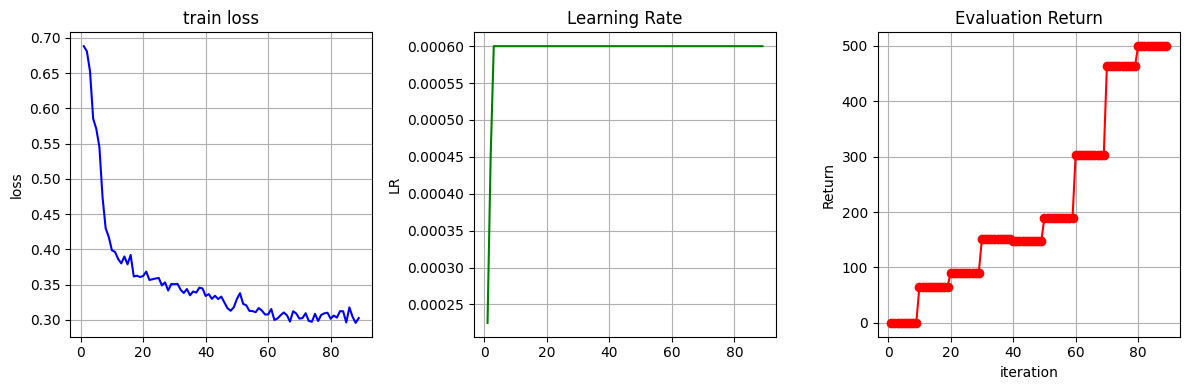

KeyboardInterrupt: 

In [21]:
import csv
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
from torch.utils.data import Dataset
from collections import deque
import random
import torch
import pickle
import argparse
# from create_dataset import create_dataset

seed = 123
context_length = 30
epochs = 1
batch_size = 128
model_type = 'reward_conditioned'
game = 'CartPole-v1'

set_seed(seed)


class StateActionReturnDataset(Dataset):

    def __init__(self, data, block_size, actions, done_idxs, rtgs, timesteps):        
        self.block_size = block_size
        self.vocab_size = max(actions) + 1
        self.data = data
        self.actions = actions
        self.done_idxs = done_idxs
        self.rtgs = rtgs
        self.timesteps = timesteps
    
    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        block_size = self.block_size // 3
        done_idx = idx + block_size
        for i in self.done_idxs:
            if i > idx: # first done_idx greater than idx
                done_idx = min(int(i), done_idx)
                break
        idx = done_idx - block_size
        states = torch.tensor(np.array(self.data[idx:done_idx]), dtype=torch.float32).reshape(block_size, -1) # (block_size, 4*84*84)
        # states = states / 255.
        actions = torch.tensor(self.actions[idx:done_idx], dtype=torch.long).unsqueeze(1) # (block_size, 1)
        rtgs = torch.tensor(self.rtgs[idx:done_idx], dtype=torch.float32).unsqueeze(1)
        timesteps = torch.tensor(self.timesteps[idx:idx+1], dtype=torch.int64).unsqueeze(1)

        return states, actions, rtgs, timesteps

# obss, actions, returns, done_idxs, rtgs, timesteps = create_dataset(num_buffers, num_steps, game, data_dir_prefix, trajectories_per_buffer)

# set up logging

# train_dataset = StateActionReturnDataset(obss, context_length*3, actions, done_idxs, rtgs, timesteps)
train_dataset = CartPoleDataset("dataset", block_size=context_length*3)
print(len(train_dataset)) # 499910
# dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
#                   n_layer=6, n_head=8, n_embd=128, model_type=model_type, max_timestep=500-1)
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  n_layer=2, n_head=2, n_embd=128, model_type=model_type, max_timestep=500-1)
model = GPT(mconf)

# initialize a trainer instance and kick off training
epochs = epochs
tconf = TrainerConfig(max_epochs=epochs, batch_size=batch_size, learning_rate=6e-4,
                      lr_decay=True, warmup_tokens=512*20, final_tokens=1e-6*2*len(train_dataset)*context_length*3,
                      num_workers=0, seed=seed, model_type=model_type, game=game, max_timestep=500-1)
trainer = Trainer(model, train_dataset, None, tconf)

trainer.train()

In [22]:
def validate_dt_model(model=None,config=None, checkpoint_path=None, num_episodes=10, target_return=500, visualize=True):
    if checkpoint_path is not None:
        print(f"Загрузка модели из чекпоинта: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path)
        
        if 'config' in checkpoint:
            config = checkpoint['config']
        elif config is None:
            raise ValueError("Конфигурации нет :(")
        
        model.load_state_dict(checkpoint['model_state_dict'])
        
        if 'eval_return' in checkpoint:
            print(f"Загружена модель с eval_return: {checkpoint['eval_return']}")
    else:
        if model is None or config is None:
            raise ValueError("Необходимо указать либо model и config, либо checkpoint_path")
    
    print(f"Валидация Decision Transformer на {num_episodes} эпизодах")
    print(f"Целевая награда (target_return): {target_return}")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    render_mode = "human" if visualize else None
    env = gym.make(config.game, render_mode=render_mode)
    
    model.eval()

    rewards = []
    episode_lengths = []
    
    for episode in range(num_episodes):
        print(f"\nЭпизод {episode+1}/{num_episodes}")
        
        state, _ = env.reset()
        state_tensor = torch.tensor(state, dtype=torch.float32).to(device).unsqueeze(0).unsqueeze(0)
        
        rtgs = [target_return]
        
        sampled_action = sample(
            model, 
            state_tensor, 
            1, 
            temperature=1.0, 
            sample=True, 
            actions=None, 
            rtgs=torch.tensor(rtgs, dtype=torch.long).to(device).unsqueeze(0).unsqueeze(-1),
            timesteps=torch.zeros((1, 1, 1), dtype=torch.int64).to(device)
        )
        
        j = 0
        total_reward = 0
        all_states = state_tensor
        actions = []
        done = False
        
        while not done:
            action = int(sampled_action.cpu().numpy()[0, -1])
            actions.append(sampled_action)
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            j += 1
            
            if done:
                print(f"Эпизод завершен: длина = {j}, награда = {total_reward}")
                rewards.append(total_reward)
                episode_lengths.append(j)
                break
            
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
            all_states = torch.cat([all_states, next_state_tensor], dim=0)
            
            rtgs.append(rtgs[-1] - reward)
            
            sampled_action = sample(
                model, 
                all_states.unsqueeze(0), 
                1, 
                temperature=1.0, 
                sample=True,
                actions=torch.tensor(actions, dtype=torch.long).to(device).unsqueeze(1).unsqueeze(0),
                rtgs=torch.tensor(rtgs, dtype=torch.long).to(device).unsqueeze(0).unsqueeze(-1),
                timesteps=(min(j, config.max_timestep) * torch.ones((1, 1, 1), dtype=torch.int64).to(device))
            )
    
    env.close()
    
    avg_reward = sum(rewards) / len(rewards)
    avg_length = sum(episode_lengths) / len(episode_lengths)
    print("\n=== Результаты валидации ===")
    print(f"Средняя награда: {avg_reward:.2f}")
    print(f"Средняя длина эпизода: {avg_length:.2f}")
    print(f"Максимальная награда: {max(rewards)}")
    print(f"Минимальная награда: {min(rewards)}")
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_episodes+1), rewards, 'b-o')
    plt.axhline(y=avg_reward, color='r', linestyle='--', label=f'Среднее: {avg_reward:.2f}')
    plt.title('Награды по эпизодам')
    plt.xlabel('Эпизод')
    plt.ylabel('Награда')
    plt.grid(True)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_episodes+1), episode_lengths, 'g-o')
    plt.axhline(y=avg_length, color='r', linestyle='--', label=f'Среднее: {avg_length:.2f}')
    plt.title('Длина эпизодов')
    plt.xlabel('Эпизод')
    plt.ylabel('Количество шагов')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    from IPython.display import display
    display(plt.gcf())
    plt.close()
    
    return {
        'rewards': rewards,
        'lengths': episode_lengths,
        'avg_reward': avg_reward,
        'avg_length': avg_length
    }


# results = validate_dt_model(checkpoint_path="dt_best_CartPole-v1_500.pt", num_episodes=10, target_return=500, visualize=True)
# results = validate_dt_model(model=model, config=tconf, num_episodes=10, target_return=500, visualize=True)

Загрузка модели из чекпоинта: ckpt/dt_best_CartPole-v1.pt
Загружена модель с eval_return: 499.5
Валидация Decision Transformer на 5 эпизодах
Целевая награда (target_return): 500

Эпизод 1/5


/var/folders/f0/0xhx91q16n920psr653s8_0m0000gn/T/ipykernel_9297/1824461013.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
2025-

Эпизод завершен: длина = 500, награда = 500.0

Эпизод 2/5
Эпизод завершен: длина = 227, награда = 227.0

Эпизод 3/5
Эпизод завершен: длина = 500, награда = 500.0

Эпизод 4/5
Эпизод завершен: длина = 500, награда = 500.0

Эпизод 5/5
Эпизод завершен: длина = 500, награда = 500.0

=== Результаты валидации ===
Средняя награда: 445.40
Средняя длина эпизода: 445.40
Максимальная награда: 500.0
Минимальная награда: 227.0


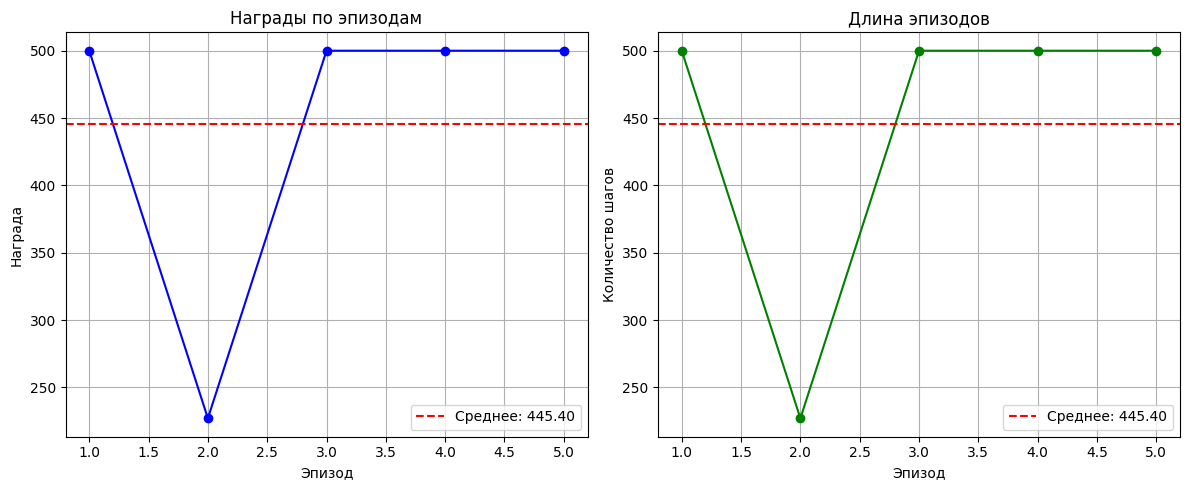

: 

In [23]:
results = validate_dt_model(
    model=model,
    checkpoint_path="ckpt/dt_best_CartPole-v1.pt",
    num_episodes=5,
    target_return=500,
    visualize=True
)